In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import umap 
from omegaconf import OmegaConf
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from dinov2.models.vision_transformer import vit_large
from dinov2.models import build_model_from_cfg
from dinov2.utils.utils import load_pretrained_weights
from dinov2.train.ssl_meta_arch import SSLMetaArch

## Model number 1.

This model was trained on the datasets before they were massively fed by Manon (around 50k images)

In [5]:
config_path = "/home/guevel/OT4D/cell_similarity/vit_large_multidataset/config.yaml"
cfg = OmegaConf.load(config_path)

model = SSLMetaArch(cfg).to(torch.device("cuda"))

ckpt_path = "/home/guevel/OT4D/cell_similarity/vit_large_multidataset/model_final.rank_0.pth"
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict["model"])

/home/guevel/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<All keys matched successfully>

In [6]:
student = model.student.backbone
teacher = model.teacher.backbone
del(model)
del(state_dict)

torch.cuda.empty_cache()

In [7]:
teacher.eval()
teacher.cuda()
student.eval()
student.cuda()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): BlockChunk(
      (0-5): 6 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): DropPath()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFNFused(
          (w12): Linear(in_features=1024, out_features=5472, bias=True)
          (w3): Linear(in_features=2736, out_features=1024, bias=True)
        )
        (ls2): LayerScale()
        (drop_path2): DropPath()
      )
    )
    (1): BlockC

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),    
    transforms.ToTensor()
])


data_path = "/home/manon/classification/data/Single_cells/barcelona"
dataset = ImageFolder(data_path, transform=transform)


dataloader = DataLoader(dataset, batch_size=64)

In [9]:
from tqdm import tqdm

embeddings_teacher = []
embeddings_student = []
labels = []
for batch, lab in tqdm(dataloader):
    batch, lab = batch.cuda(), lab
    with torch.no_grad():
        outputs_teacher = teacher(batch)
        embeddings_teacher.append(outputs_teacher.cpu())
        
        outputs_student = student(batch)
        embeddings_student.append(outputs_student.cpu())
        
        labels.append(lab)
    torch.cuda.empty_cache()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [12:27<00:00,  2.79s/it]


In [10]:
emb_t = torch.cat(embeddings_teacher)
emb_s = torch.cat(embeddings_student)
labs = torch.cat(labels)
print(emb_t.shape, emb_s.shape)

torch.Size([17101, 1024]) torch.Size([17101, 1024])


In [17]:
# torch.save(emb_t, "cache/barcelona_embs_vitl_teacher.pt")
# torch.save(emb_s, "cache/barcelona_embs_vitl_student.pt")
# torch.save(labs, "cache/barcelona_labels.pt")

In [12]:
import umap

uemb_t = umap.UMAP().fit_transform(emb_t)
uemb_s = umap.UMAP().fit_transform(emb_s)

In [13]:
paths = [pair[0] for pair in dataset.imgs]
data = []
translate = {v: k for k, v in dataset.class_to_idx.items()}

for e, path, c in zip(uemb_t, paths, labs):
    data.append([e[0], e[1], translate[c.tolist()], path, "teacher"])

for e, path, c in zip(uemb_s, paths, labs):
    data.append([e[0], e[1], translate[c.tolist()], path, "student"])

In [15]:
df_emb = pd.DataFrame(data, columns=["x", "y", "class", "name", "model"])
df_emb.head()

,x,y,class,name,model
0,11.044542,6.870373,band_neutrophil,/home/manon/classification/data/Single_cells/b...,teacher
1,12.398626,7.020848,band_neutrophil,/home/manon/classification/data/Single_cells/b...,teacher
2,11.529996,7.944479,band_neutrophil,/home/manon/classification/data/Single_cells/b...,teacher
3,12.212569,8.321896,band_neutrophil,/home/manon/classification/data/Single_cells/b...,teacher
4,11.076377,4.262932,band_neutrophil,/home/manon/classification/data/Single_cells/b...,teacher


<Figure size 1200x1600 with 0 Axes>

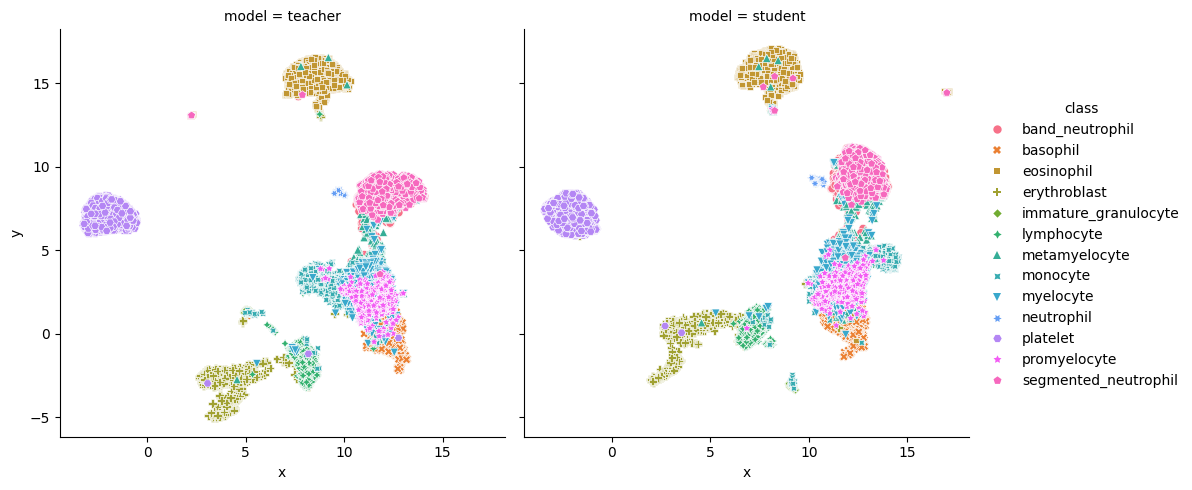

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df_emb.copy()


plt.figure(figsize=(12,16))
sns.relplot(
    data=df_plot,
    x="x", y="y", hue="class", style="class", col="model"
)
plt.show()

In [31]:
del(teacher)
del(student)

## Model number 2.

The architecture of the 2 models are the same but this model received ameliorations :

- included the registry tokens in the training (4)
- more training data ~400k images

In [6]:
from cell_similarity.configs import default_config

cfg_path = "/home/guevel/OT4D/cell_similarity/vitl_register/config.yaml"
default_cfg = OmegaConf.create(default_config)
cfg = OmegaConf.load(cfg_path)
cfg = OmegaConf.merge(cfg, default_cfg)

In [7]:
model, _ = build_model_from_cfg(cfg, only_teacher=True)
path_model = "/home/guevel/OT4D/cell_similarity/vitl_register/eval/training_124999/teacher_checkpoint.pth"
load_pretrained_weights(model, path_model, "teacher")

In [8]:
model.eval()
model.cuda()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): BlockChunk(
      (0-5): 6 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFNFused(
          (w12): Linear(in_features=1024, out_features=5472, bias=True)
          (w3): Linear(in_features=2736, out_features=1024, bias=True)
        )
        (ls2): LayerScale()
        (drop_path2): Identity()
      )
    )
    (1): BlockC

### Barcelona dataset

In [9]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),    
    transforms.ToTensor()
])


data_path = "/home/manon/classification/data/Single_cells/barcelona"
dataset = ImageFolder(data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64)

In [10]:
from tqdm import tqdm

labels = []
embeddings = []
for batch, lab in tqdm(dataloader):
    batch, lab = batch.cuda(), lab
    with torch.no_grad():
        outputs = model(batch)
        embeddings.append(outputs.cpu())
        
        labels.append(lab)
    torch.cuda.empty_cache()

emb = torch.cat(embeddings)
labs = torch.cat(labels)
# torch.save(emb, 'cache/barcelona_embs_vitl_register.pt')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [06:03<00:00,  1.36s/it]


In [12]:
uemb_ = umap.UMAP().fit_transform(emb)

paths = [pair[0] for pair in dataset.imgs]
data = []
translate = {v: k for k, v in dataset.class_to_idx.items()}

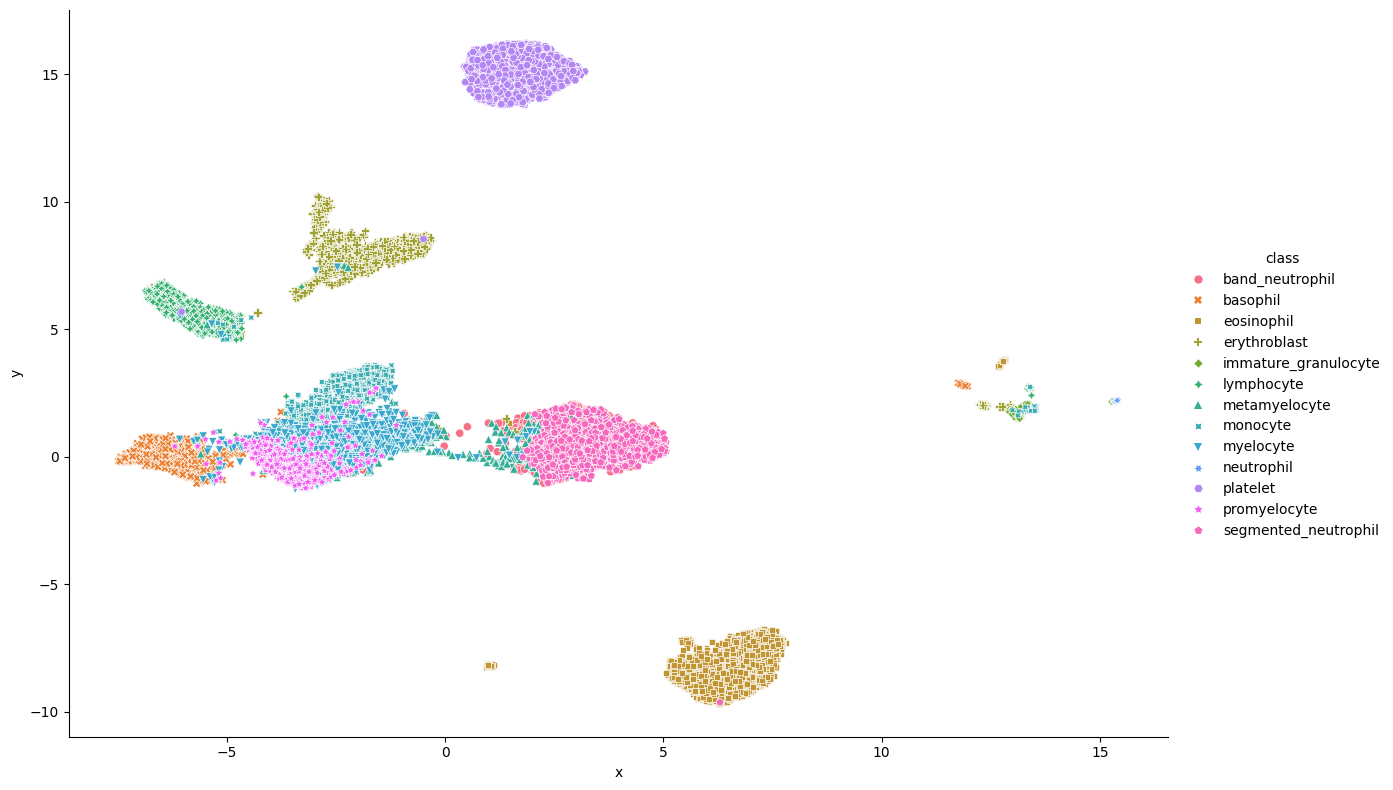

In [13]:
for e, path, c in zip(uemb_, paths, labs):
    data.append([e[0], e[1], translate[c.tolist()], path, "teacher"])

df_emb = pd.DataFrame(data, columns=["x", "y", "class", "name", "model"])
df_plot = df_emb.copy()

sns.relplot(
    data=df_plot,
    x="x", y="y", hue="class", style="class", height=8, aspect=1.5
)
plt.savefig("umap_barcelona.png")
plt.show()

## plot RGB

In [16]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

def calibrate_pca(img):
    n = img.shape[0]
    img = img.cuda()
    with torch.no_grad():
        patches = model.get_intermediate_layers(img)

    # calibrate PCA for background
    im_test = patches[0].cpu().numpy()
    
    pca_fg = PCA(n_components=1)
    pca_features = pca_fg.fit_transform(im_test.reshape([-1, 1024]))
    norm_patches = minmax_scale(pca_features)
    pca1 = norm_patches.copy()
    # separate from background
    image_norm_patches = norm_patches.reshape([n,patch_h * patch_w])
    im_test[image_norm_patches > 0.6] = 0
    
    # calibrate PCA for RGB
    pca_rgb = PCA(n_components=3)
    pca_features = pca_rgb.fit_transform(im_test.reshape([-1, 1024]))
    norm_patches = minmax_scale(pca_features)
    
    return pca_fg, pca_rgb, pca1

In [17]:
patch_h=40
patch_w=40

t = transforms.ToPILImage()
transform = transforms.Compose([
    transforms.GaussianBlur(9, sigma=(0.1, 2.0)),
    transforms.Resize((patch_h * 14, patch_w * 14)),
    transforms.CenterCrop((patch_h * 14, patch_w * 14)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

dataset_ = ImageFolder(data_path, transform=transform)
dataloader_ = DataLoader(dataset_, batch_size=64)

for batch, lab in dataloader_:
    break

pca_fg, pca_rgb, pca1 = calibrate_pca(batch)

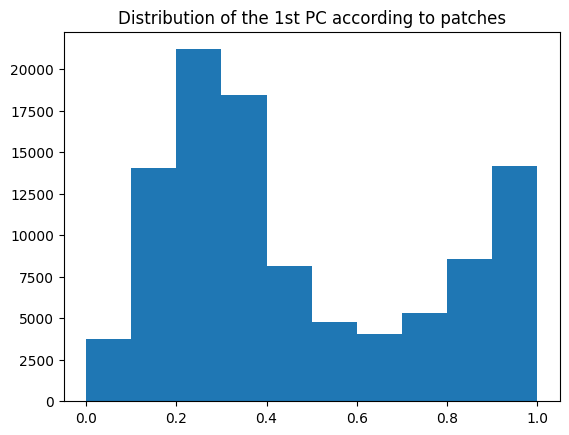

In [21]:
plt.hist(pca1)
plt.title("Distribution of the 1st PC according to patches")
plt.show()

>This graph shows that there are two distributions grouped together inside the 1st PC that can be separated with a threshold of ~0.6

In [24]:
def view_pca(im, pca_fg, pca_rgb, tsh, plot=True,):
    
    img = transform(im).unsqueeze(0).cuda()
    with torch.no_grad():
        patches = model.get_intermediate_layers(img)

    # calibrate PCA
    im_test = patches[0][0,:,:].cpu().numpy()
    pca_features = pca_rgb.transform(im_test)
    norm_patches = minmax_scale(pca_features)
    
    pca_features_bg = norm_patches[:, 0] < tsh
    pca_features_fg = ~pca_features_bg

    im_tresh = pca_features_bg.reshape(patch_h, patch_w)

    # PCA for only foreground patches
    pca_features_rem = pca_rgb.transform(im_test[pca_features_fg])
    pca_features_rem = minmax_scale(pca_features_rem)
    
    pca_features_rgb = pca_features.copy()
    pca_features_rgb[pca_features_bg] = 0
    pca_features_rgb[pca_features_fg] = pca_features_rem
    im_rgb = pca_features_rgb.reshape(patch_w, patch_h, 3)  

    # plot the images
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(im)
    axes[1].imshow(im_tresh, cmap='hot')
    axes[2].imshow(im_rgb)
    if plot:
        plt.show()
    plt.close(fig)
    
    return im, im_tresh, im_rgb

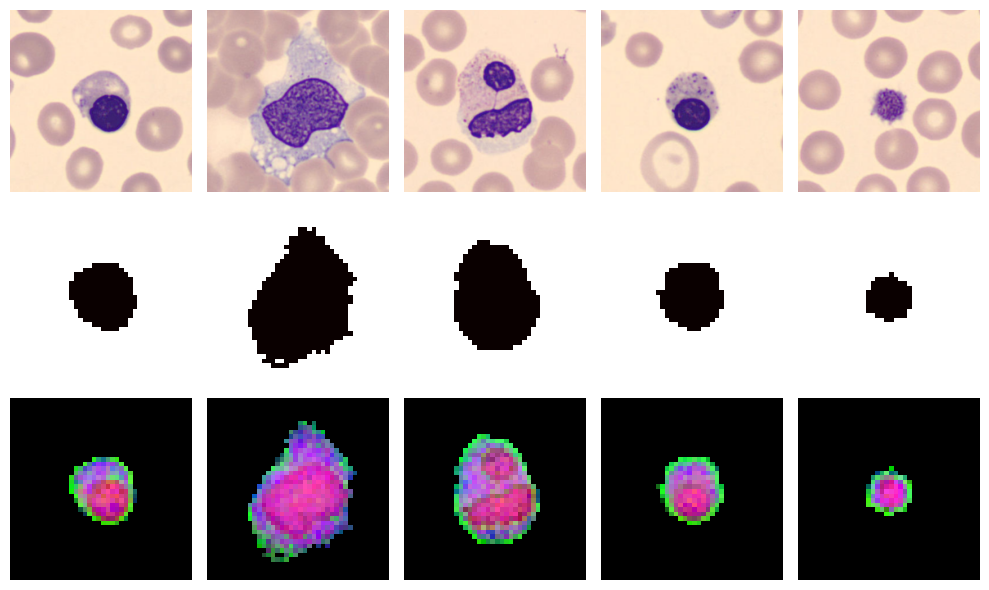

In [25]:
import random

tsh = 0.6

random.seed(111)
sample = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(3, 5, figsize=(2 * 5, 2 * 3))
for i, k in enumerate(sample):
    img = t(dataset[k][0])
    im, im_tsh, im_rgb = view_pca(img, pca_fg, pca_rgb, tsh, plot=False)
    axes[0, i].imshow(im)
    axes[1, i].imshow(im_tsh, cmap='hot')
    axes[2, i].imshow(im_rgb)
    for row in range(3):
        axes[row, i].axis('off')

plt.tight_layout()
plt.savefig("cells_rgb.png")
plt.show()